
Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.13      0.05      0.07       486
           1       0.41      0.66      0.51       486

    accuracy                           0.35       972
   macro avg       0.27      0.35      0.29       972
weighted avg       0.27      0.35      0.29       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.69      0.82       486
           1       0.77      1.00      0.87       486

    accuracy                           0.85       972
   macro avg       0.88      0.85      0.84       972
weighted avg       0.88      0.85      0.84       972



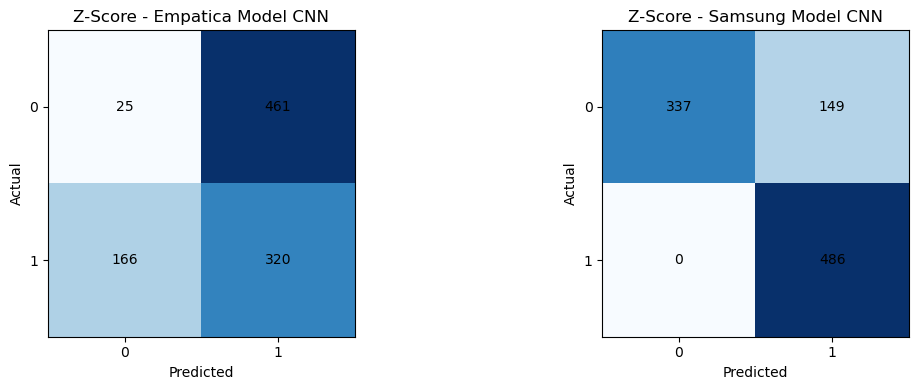

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/z-score/a_training.csv"
testing_file_path = "./data/6-data-split/z-score/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 64, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 64, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Z-Score - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Z-Score - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()


Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.02      0.00      0.01       486
           1       0.43      0.74      0.54       486

    accuracy                           0.37       972
   macro avg       0.22      0.37      0.27       972
weighted avg       0.22      0.37      0.27       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.08      0.15       486
           1       0.52      1.00      0.68       486

    accuracy                           0.54       972
   macro avg       0.76      0.54      0.42       972
weighted avg       0.76      0.54      0.42       972



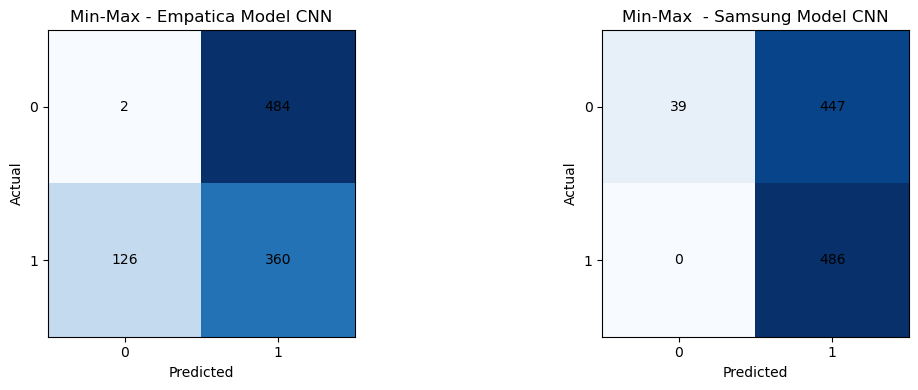

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/min-max/a_training.csv"
testing_file_path = "./data/6-data-split/min-max/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 64, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 64, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Min-Max - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Min-Max  - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()


Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.23      0.11      0.15       486
           1       0.42      0.63      0.50       486

    accuracy                           0.37       972
   macro avg       0.32      0.37      0.33       972
weighted avg       0.32      0.37      0.33       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.47      0.64       486
           1       0.65      1.00      0.79       486

    accuracy                           0.74       972
   macro avg       0.83      0.74      0.72       972
weighted avg       0.83      0.74      0.72       972



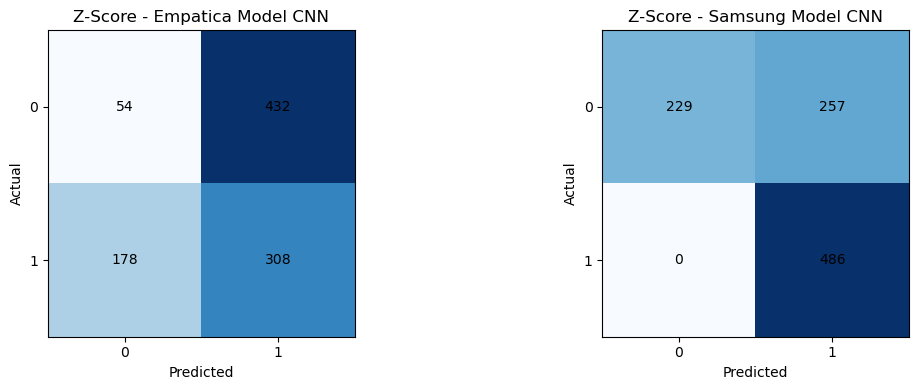

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/z-score/a_training.csv"
testing_file_path = "./data/6-data-split/z-score/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 126, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 128, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Z-Score - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Z-Score - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()

24/03/20 12:40:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed



Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       486
           1       0.49      0.95      0.64       486

    accuracy                           0.47       972
   macro avg       0.24      0.47      0.32       972
weighted avg       0.24      0.47      0.32       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.60      0.75       486
           1       0.71      1.00      0.83       486

    accuracy                           0.80       972
   macro avg       0.86      0.80      0.79       972
weighted avg       0.86      0.80      0.79       972



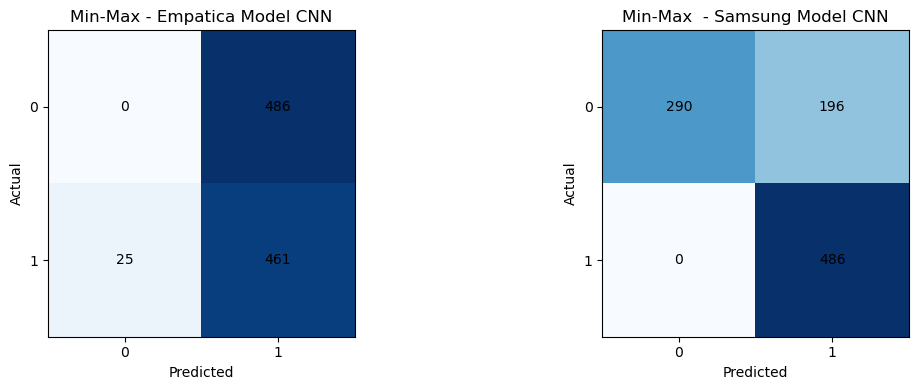

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/min-max/a_training.csv"
testing_file_path = "./data/6-data-split/min-max/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 126, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 128, 32, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Min-Max - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Min-Max  - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()


Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.08      0.02      0.04       486
           1       0.42      0.70      0.52       486

    accuracy                           0.36       972
   macro avg       0.25      0.36      0.28       972
weighted avg       0.25      0.36      0.28       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.38      0.55       486
           1       0.62      1.00      0.76       486

    accuracy                           0.69       972
   macro avg       0.81      0.69      0.66       972
weighted avg       0.81      0.69      0.66       972



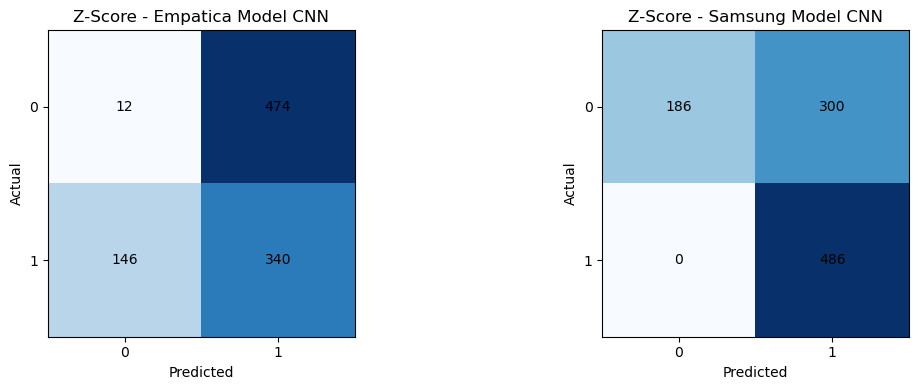

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/z-score/a_training.csv"
testing_file_path = "./data/6-data-split/z-score/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 16, 8, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 16, 8, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Z-Score - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Z-Score - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()


Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.27      0.14      0.18       486
           1       0.42      0.63      0.50       486

    accuracy                           0.38       972
   macro avg       0.34      0.38      0.34       972
weighted avg       0.34      0.38      0.34       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.18      0.30       486
           1       0.55      1.00      0.71       486

    accuracy                           0.59       972
   macro avg       0.77      0.59      0.51       972
weighted avg       0.77      0.59      0.51       972



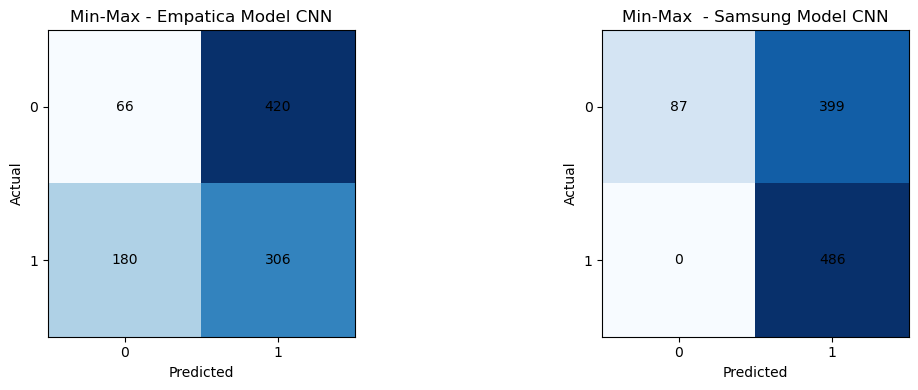

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a SparkSession
spark = SparkSession.builder.appName("CNNWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/min-max/a_training.csv"
testing_file_path = "./data/6-data-split/min-max/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector for Empatica
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)

# Assemble feature vector for Samsung
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Guidance for exploring CNN hyperparameters and tuning, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
cnn_empatica = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_empatica), 16, 8, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_empatica",
    labelCol="CL",
)

# Define CNN model for Samsung
cnn_samsung = MultilayerPerceptronClassifier(
    layers=[len(feature_columns_samsung), 16, 8, 2],
    blockSize=128,
    seed=1234,
    featuresCol="features_samsung",
    labelCol="CL",
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, cnn_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, cnn_samsung])

# Train the models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions for
predictions_empatica = model_empatica.transform(testing_df)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")

predictions_samsung = model_samsung.transform(testing_df)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")

# Guidance for extracting predicted and true labels for Empatica Model (RF)
# and transform into confusion matrix bi-dimensional space, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Print classification reports for both devices
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Compute confusion matrices
conf_mat_empatica_cnn = confusion_matrix(y_true_empatica_cnn, y_pred_empatica_cnn)
conf_mat_samsung_cnn = confusion_matrix(y_true_samsung_cnn, y_pred_samsung_cnn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Empatica confusion matrix
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("Min-Max - Empatica Model CNN")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Plot Samsung confusion matrix
axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("Min-Max  - Samsung Model CNN")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the plots
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()